In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.cartocolors.qualitative import Safe_4
from pysteps.visualization.spectral import plot_spectrum1d

In [3]:
plt.style.use("bmh")
hex_colors = Safe_4.hex_colors
methods_params = {
    "steps" : {
        "color" : hex_colors[0], 
        "label" : "STEPS",
    },
    "bcnn" : {
        "label" : "DEUCE mean",
        "color" : hex_colors[2], 
    },
    "bcnn member" : {
        "label" : "DEUCE member",
        "color" : hex_colors[2],
        "linestyle": "dashed", 
    },
    "linda-p" : {
        "label" : "LINDA-P",
        "color" : hex_colors[1], 
    },
    "linda-d" : {
        "label" : "LINDA-D",
        "color" : hex_colors[1], 
    },
    "extrapolation" : {
        "label" : "Extrapolation",
        "color" : hex_colors[3], 
    },
}

In [4]:
SAVE = True
BASE_DIR = Path("../data/metrics/deuce_deterministic_metrics")
SAVE_DIR = Path("../data/figures")

cat = [xr.open_dataarray(p) for p in BASE_DIR.glob("*.nc") if "CAT" in str(p)]
cat = xr.Dataset(data_vars={arr.name : arr for arr in cat}) 
cat_ds = cat.to_dataframe().reset_index()
ets = cat.sel(cat_metric="ETS")

In [5]:
ets

<xarray.Dataset>
Dimensions:        (leadtime: 12, threshold: 4)
Coordinates:
  * leadtime       (leadtime) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * threshold      (threshold) int32 20 25 35 45
    cat_metric     <U3 'ETS'
Data variables:
    bcnn           (threshold, leadtime) float64 0.7067 0.6283 ... 3.657e-05
    extrapolation  (threshold, leadtime) float64 0.6865 0.5996 ... 0.004519
    linda-d        (threshold, leadtime) float64 0.7018 0.6134 ... 0.003492

In [6]:
for model in ets:
    print(model, np.round(ets[model].mean(dim="leadtime").values,3))

bcnn [0.442 0.299 0.047 0.006]
extrapolation [0.434 0.341 0.134 0.049]
linda-d [0.454 0.371 0.162 0.056]


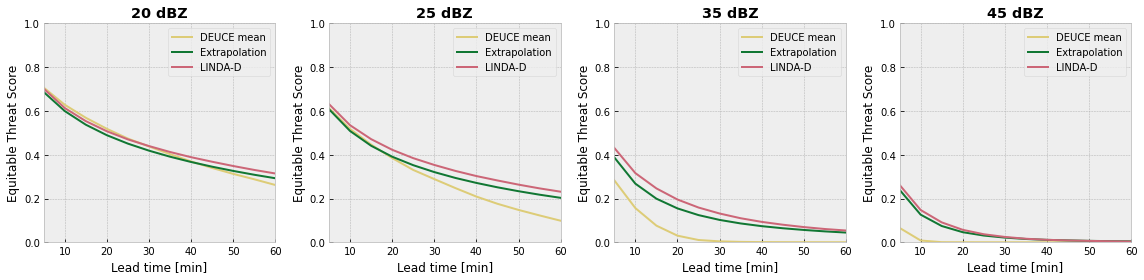

In [7]:
lts = (ets.leadtime * 5).astype(int)
fig, axs = plt.subplots(ncols=4, figsize=(4*len(ets.threshold),4))
for i, thr in enumerate(ets.threshold):
    for model in ets:
        axs[i].plot(lts, ets[model].sel(threshold=thr),c=methods_params[model]["color"], label=methods_params[model]["label"])
    axs[i].set_ylim([0,1])
    axs[i].set_ylabel("Equitable Threat Score")
    axs[i].set_xlim([lts.min(), lts.max()])
    axs[i].set_xlabel("Lead time [min]")
    axs[i].legend()
    axs[i].set_title(f"{thr.values} dBZ",fontweight="semibold")
fig.tight_layout()
if SAVE:
    fig.savefig(SAVE_DIR / "ETS_ALL.pdf",bbox_inches='tight')

In [8]:
rapsd = [xr.open_dataarray(p) for p in BASE_DIR.glob("*.nc") if "RAPSD" in str(p)]
rapsd = xr.Dataset(data_vars={arr.name : arr for arr in rapsd}) 

In [9]:
RM_DIR = Path("../data/metrics/deuce_rapsd_member_metric/")
rapsd_member = [xr.open_dataarray(p) for p in RM_DIR.glob("RAPSD_bcnn.nc")]
rapsd.update({arr.name + " member" : arr for arr in rapsd_member})

<xarray.Dataset>
Dimensions:        (freq: 256, leadtime: 4, type: 2)
Coordinates:
  * freq           (freq) float64 0.0 0.001953 0.003906 ... 0.4941 0.4961 0.498
  * leadtime       (leadtime) int32 1 3 6 12
  * type           (type) object 'prediction' 'observation'
Data variables:
    bcnn           (type, leadtime, freq) float64 ...
    extrapolation  (type, leadtime, freq) float64 ...
    linda-d        (type, leadtime, freq) float64 ...
    bcnn member    (type, leadtime, freq) float64 ...

In [10]:
rapsd

<xarray.Dataset>
Dimensions:        (freq: 256, leadtime: 4, type: 2)
Coordinates:
  * freq           (freq) float64 0.0 0.001953 0.003906 ... 0.4941 0.4961 0.498
  * leadtime       (leadtime) int32 1 3 6 12
  * type           (type) object 'prediction' 'observation'
Data variables:
    bcnn           (type, leadtime, freq) float64 ...
    extrapolation  (type, leadtime, freq) float64 ...
    linda-d        (type, leadtime, freq) float64 ...
    bcnn member    (type, leadtime, freq) float64 ...

In [11]:
for model in rapsd:
    print(model, np.round((np.abs(rapsd[model].sel(type="prediction") - rapsd[model].sel(type="observation"))/rapsd[model].sel(type="observation")).mean(dim="freq").values, 2))

bcnn [0.55 0.74 0.84 0.9 ]
extrapolation [0.08 0.08 0.07 0.11]
linda-d [0.39 0.52 0.58 0.65]
bcnn member [0.51 0.68 0.76 0.78]


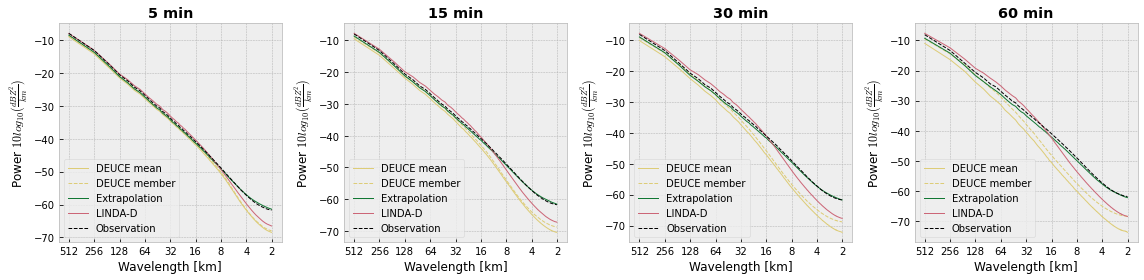

In [12]:
ticks = np.array([2**n for n in range(1,10)])
fig, axs = plt.subplots(ncols=4, figsize=(4*len(ets.threshold),4))
for i, lt in enumerate(rapsd.leadtime):
    for model in sorted(list(rapsd.keys())):
        plot_spectrum1d(
            fft_freq=rapsd.freq,
            fft_power=rapsd[model].sel(leadtime=lt,type="prediction"),
            color=methods_params[model]["color"],
            linestyle=methods_params[model].get("linestyle","solid"),
            x_units="km",
            y_units="dBZ",
            wavelength_ticks=ticks,
            ax=axs[i],
            label=methods_params[model]["label"]
            )
    plot_spectrum1d(
            fft_freq=rapsd.freq,
            fft_power=rapsd[model].sel(leadtime=lt,type="observation"),
            color="k",
            linestyle="--",
            x_units="km",
            y_units="dBZ",
            wavelength_ticks=ticks,
            ax=axs[i],
            label="Observation"
            )
    axs[i].legend(loc="lower left")
    axs[i].set_title(f"{lt.values * 5} min",fontweight="semibold")
fig.tight_layout()
if SAVE:
    fig.savefig(SAVE_DIR / "RAPSD_ALL.pdf",bbox_inches='tight')

In [13]:
cont = [xr.open_dataarray(p) for p in BASE_DIR.glob("*.nc") if "CONT" in str(p)]
cont = xr.Dataset(data_vars={arr.name : arr for arr in cont}) 

In [14]:
cont

<xarray.Dataset>
Dimensions:        (leadtime: 12, cont_metric: 2)
Coordinates:
  * leadtime       (leadtime) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * cont_metric    (cont_metric) object 'MAE' 'ME'
Data variables:
    bcnn           (cont_metric, leadtime) float64 ...
    extrapolation  (cont_metric, leadtime) float64 ...
    linda-d        (cont_metric, leadtime) float64 ...

In [15]:
for model in cont:
    print(model, cont[model].sel(cont_metric="ME").mean(dim="leadtime").values)

bcnn -1.3122144391225563
extrapolation -0.3481635850748943
linda-d 0.5332460210696508


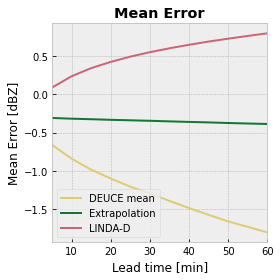

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
for model in cont:
    ax.plot(cont.leadtime * 5, cont[model].sel(cont_metric="ME"),c=methods_params[model]["color"], label=methods_params[model]["label"])
ax.legend()
ax.set_xlim([5,60])
ax.set_xlabel("Lead time [min]")
ax.set_ylabel("Mean Error [dBZ]")
ax.set_title("Mean Error", fontweight="semibold")
fig.tight_layout()
if SAVE:
    fig.savefig(SAVE_DIR / "ALL_ME.pdf",bbox_inches='tight')